<a href="https://colab.research.google.com/github/mbalbi/ciencia_de_datos/blob/main/tps/1c2024/Practica_5_completa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clase 5: Probabilidad y simulación de variables aleatorias

El objetivo de la clase de hoy es hacer un repaso de probabilidad, con énfasis en el cálculo numérico de probabilidades y la extracción de distintos parámetros mediante simulación.

En el camino veremos distintas funciones de distribución de probabilidad, cómo simularlas y presentar los resultados, ya sea mediante histogramas, o curvas empíricas de densidad o de probabilidad acumulada.

Si bien en algunos momentos se presentarán resultados analíticos utilizando la librería `scipy stats`, esto es solo a fines ilustrativos, y a lo largo del curso todo problema que requiera realizar cálculos probabilísticos podrán realizarse con `numpy` más la herramientas de inferencia estadística que veremos más adelante.

In [2]:
# Importar librerías
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import scipy.stats as st

## Funciones de distribución de probabilidad (univariadas)

Empecemos por hacer un breve repaso de **algunas** de las funciones de densidad de probabilidad que pueden ir apareciendo en el curso, más que nada para ver para qué pueden servir y cómo son. Claramente no vamos a cubrir todas, y llegado el caso se las presentaremos y ustedes buscarán más información al respecto (por lo menos, de cómo incorporarlas en Python).

### Variables aleatorias discretas

Primero, recordemos un poco distintos modelos de variables discretas. Empezando por modelos binarios, donde la variable `x` solo toma 2 valores, `éxito=1` y `no éxito=0`. Por ejemplo, el resultado de tirar un dado, la variable colapso de una estructura, la variable inundación de un área, etc.

#### Distribución de Bernoulli

Si quiero analizar **nn** evento de una variable aleatoria como la anterior, el resultado sigue una distribución de Bernoulli, donde la probabilidad de éxito o no éxito es:

$$p(x=k | p ) = p^{k}\left(1-p\right)^\left(1-k\right),\ k=0,1$$

Noten la nomenclatura: $x$ es la variable aleatoria, $k$ es el valor que puede tomar (0 o 1), y $p(x=k | p )$ es la probabilidad de que la variable aleatoria tome ese valor determinado **dado el parámetro p**. Es decir, dado un valor (conocido o adoptado) para la probabilidad de éxito.

Esta nomenclatura (algo más larga), va a ser mantenida a lo largo del curso, para dejar en claro que en este caso la probabilidad es condicional a sus parámetros.

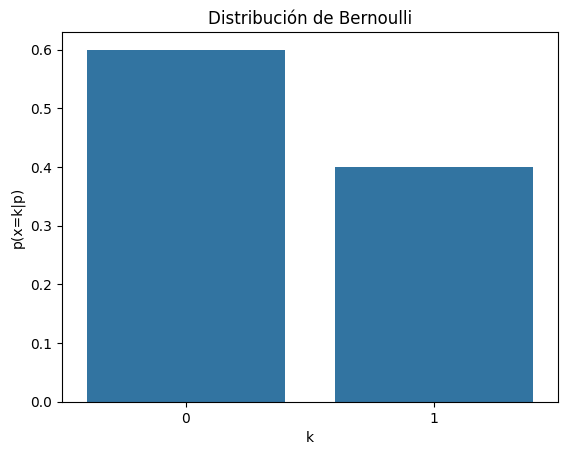

In [3]:
p = 0.4 # Probabilidad de éxito

k = [0,1] # Valores que puede tomar x
pk = [1-p,p] # Probabilidades asignadas a cada resultado posible

sns.barplot(pd.DataFrame({'k':k,'p(x=k|p)':pk}),x='k',y='p(x=k|p)').set(
    title='Distribución de Bernoulli')
plt.show()

#### Distribución Binomial

Avancemos con la extensión de la distribución de Bernoulli para la repeticicón de eventos independientes entre sí, lo que se conoce como un *proceso de Bernoulli*. Queda definida por 2 variables, la probabilidad de éxito dado un evento `p` y el número de eventos `n`. Se puede demostrar que la distribución de Bernoulli es el caso particular de una binomial con `n=1`.

La función define entonces la probabilidad de `x` éxitos (de `0` a `n`) dado `n` eventos (por ejemplo, la probabilidad de que se inunde 2 veces dado 3 tormentas). El resultado es entonces un conteo (suma) del caso anterior repetido `n` veces en forma independiente.

$$p(x=k | p, n ) = \begin{pmatrix} n \\ k \end{pmatrix} p^{k}\left(1-p\right)^\left(n-k\right),\ k=0,1,\dots,n$$

Verán que ahora la fórmula no es tan linda (porque tengo que calcular la combinatoria). Abajo les muestro la solución análitica, pero quiero que después pensemos cómo obtenerla por simulación.

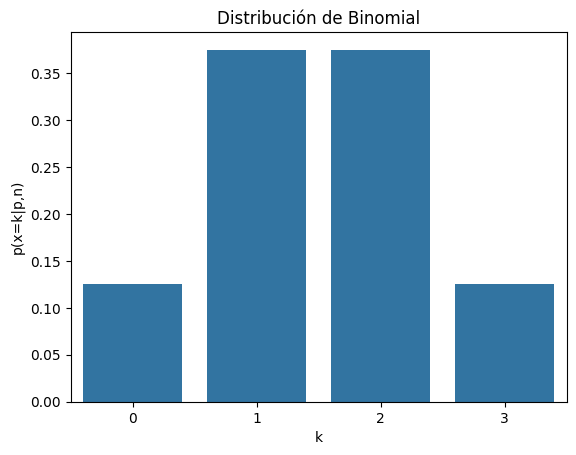

In [4]:
p = 0.5 # probabilidad de exito
n = 3   # numero de eventos
inunda = st.binom(n, p) # funcion de probabilidad

x = range(n+1) # valores que puede tomar la VA
dist = inunda.pmf(x) # evaluar funcion

sns.barplot(pd.DataFrame({'k':x,'p(x=k|p,n)':dist}),x='k',y='p(x=k|p,n)').set(
    title='Distribución de Binomial')
plt.show()

Pensemos ahora como obtener ese mismo gráfico pero a partir de la simulación del proceso de Bernoulli. La primera opción sería con `np.random`, un conjunto de opciones que permite simular variables aleatorias.

In [5]:
# Seteo la aleatoriedad
rng = np.random.default_rng(10)

# Hago la simulacion
p = 0.5 # probabilidad de exito
n = 3   # numero de eventos
sim = rng.binomial(n,p)
print(sim)

3


Como ven, `np.random.binomial(n,p)` devuelve cuántos éxitos ocurrieron. ¿Por qué no lo hacemos 1000 veces?

In [6]:
# Numero de simulaciones
N = 1000

# Repito el ensayo N veces
sim_N = rng.binomial(n,p,N)
#print(sim_N)

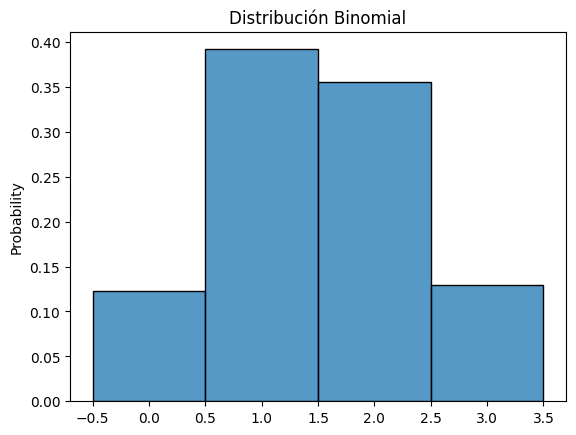

In [7]:
# Visualizacion simulaciones
sns.histplot(sim_N,label='simulación',stat='probability',discrete=True).set(
    title='Distribución Binomial')
plt.show()

Otra forma, en vez de hacer el histograma, sería hacer el conteo nosotros a mano (de paso nos vamos acostumbrando) y hacer el gráfico de barras. Es decir, ¡usamos las simulaciones para calcular probabilidades!

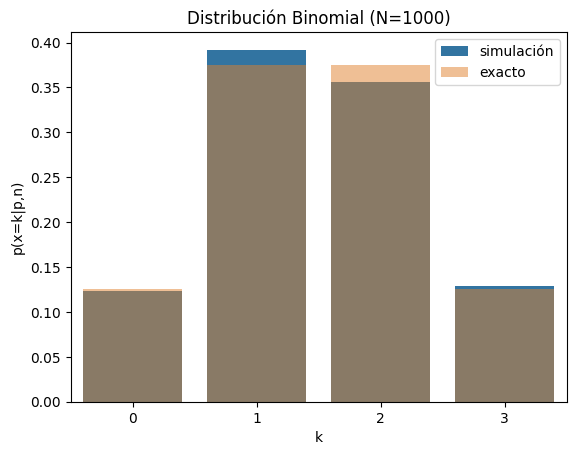

In [8]:
# Cuento cuántas veces salió cada número
props = np.array([np.mean(sim_N==xi) for xi in x])

sns.barplot(pd.DataFrame({'k':x,'p(x=k|p,n)':props}),x='k',y='p(x=k|p,n)',
            label='simulación').set(title='Distribución Binomial')
sns.barplot(pd.DataFrame({'k':x,'p(x=k|p,n)':dist}),x='k',y='p(x=k|p,n)',
            alpha=0.5,label='exacto').set(
                title='Distribución Binomial (N=1000)')
plt.show()

¡Da bastante parecido! Pero van a notar 2 cosas:

1. Que cada vez que lo corren da ligeramente distinto
2. Que cuán preciso es depende de la cantidad de simulaciones que haga

Les muestro ahora cómo hacer que los resultados sean siempre iguales (aleatorio, pero trazable), y de paso el efecto de hacer pocas o muchas simulaciones.

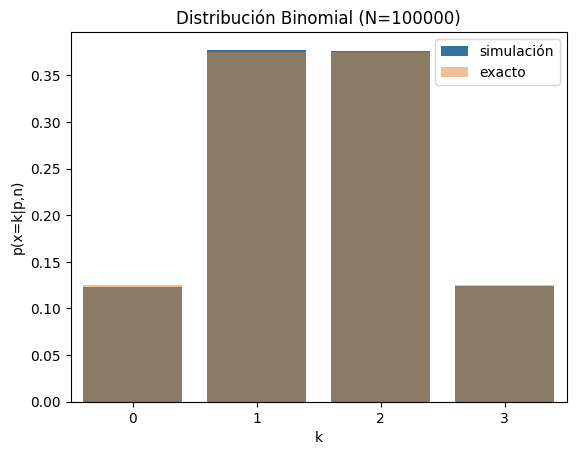

In [9]:
# Numero de simulaciones
N = 100000

# Repito el ensayo N veces
sim_N = rng.binomial(n,p,N)
#print(sim_N)
# Cuento cuántas veces salió cada número
props = np.array([np.mean(sim_N==xi) for xi in x])

sns.barplot(pd.DataFrame({'k':x,'p(x=k|p,n)':props}),x='k',y='p(x=k|p,n)',
            label='simulación').set(title='Distribución Binomial')
sns.barplot(pd.DataFrame({'k':x,'p(x=k|p,n)':dist}),x='k',y='p(x=k|p,n)',
            alpha=0.5,label='exacto').set(
                title='Distribución Binomial (N=100000)')
plt.show()

La respuesta a la pregunta "cuántas simulaciones es suficiente" se puede contestar de muchas formas. Una sería hacer muchas veces una simulación de N simulaciones y ver cuánto cambian las estimaciones empíricas.

Ahí le mostré como simular una variable cuya función de distribución está disponible en `numpy`. Pero, ¿qué hacemos si no es el caso?

Bueno, para ello tenemos que recordar que la suma de las probabilidades es 1, y que la probabilidad es siempre un número entre 0 y 1.

Entonces, podríamos por inversión obtener el valor de $k$ simulando el valor de la probabilidad. Por ejemplo, para la Bernoulli:

1. simulo una variable aleatoria uniforme entre 0 y 1, de nombre `z`
2. si `z` es menor a `p`, entonces `x=1`
3. caso contrario, `x=0`

Eso me garantiza que si simulo suficientes veces el `p` porciento de los valores serán éxitos.

¿Probamos?

In [10]:
# Numero de simulaciones: n
print(n)

# Simulo n veces una uniforme entre 0 y 1
z = rng.uniform(0,1,n)
print(z)

# Chequeo si es menor a p, eso me define la variable x
xi = z<=p
print(xi)

# Hago la sumatoria, que me da el número de exitos
xk = np.sum(xi)
print(xk)

3
[0.20679215 0.52747959 0.8721827 ]
[ True False False]
1


Y entonces, lo que queda ahora es hacer esto muchas veces nada más

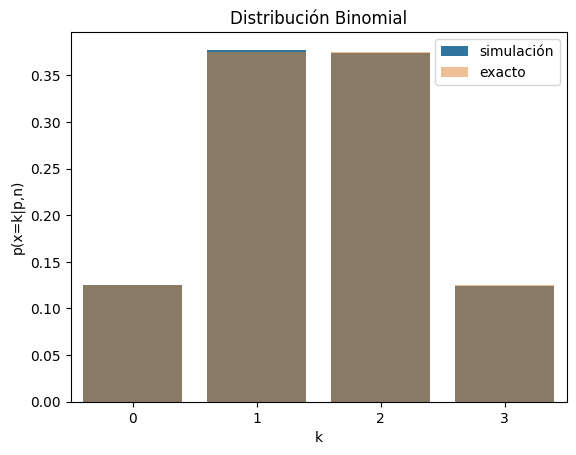

In [11]:
# Repito el ensayo N veces
z_N = rng.uniform(0,1,(N,n))
x_N = z_N<=p
sim2_N = np.sum(x_N,axis=1)

# Cuento cuántas veces salió cada número
props2 = np.array([np.mean(sim2_N==xi) for xi in range(n+1)])

sns.barplot(pd.DataFrame({'k':x,'p(x=k|p,n)':props2}),x='k',y='p(x=k|p,n)',
            label='simulación').set(title='Distribución Binomial')
sns.barplot(pd.DataFrame({'k':x,'p(x=k|p,n)':dist}),x='k',y='p(x=k|p,n)',
            alpha=0.5,label='exacto').set(title='Distribución Binomial')
plt.show()

¡Excelente! Esta herramienta tenganla en cuenta por si alguna variable no tiene función en Numpy. Es más, todo problema de simulación se resume a algo así (combinar simulaciones de cosas más sencillas).

#### Distribución de Poisson

La distribución de poisson es muy similar a la binomial. Así como la primera cuenta el número de éxitos o sucesos en un número de eventos, la distribución de poisson realiza el mismo conteo dentro de un tiempo o espacio acotado. Es decir, pasa de tener un número de eventos discreto a un intervalo continuo.

Esto hace que se reduzca el número de parámetros del modelo, pasando de 2 (probabilidad de suceso y número de eventos) a 1 (el valor esperado de sucesos). Noten que ahora los valores posibles no están acotados, `x` puede ir de 0 a infinito, pero siguen siendo números enteros.

La función de poisson se la utiliza habitualmente para modelar la ocurrencia de eventos extremos, como por ejemplo el número de sismos de magnitud dañina en la vida útil o período de diseño de una estructura.

$$p(x=k | \lambda) = \frac{e^{-\lambda}\lambda^{k}}{k!},\ k=0,1,2\dots$$

Como ya vimos, en vez de graficar la solución analítica con simulación se obtiene prácticamente el mismo gráfico así que seguiremos por esa vía. En este caso usamos la función `np.random.poisson(lam,n)`, donde `n` es cuántas veces queremos simular a la variable aleatoria.

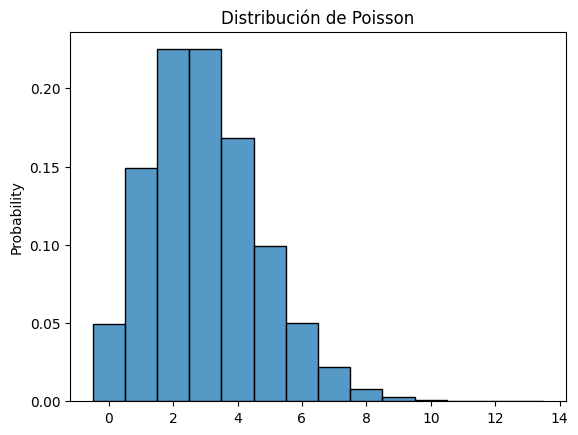

In [12]:
# Numero de simulaciones
N = 100000
# Valor esperado de sucesos
lam = 3

# Simulo
xi = rng.poisson(lam,N)

sns.histplot(xi,label='simulación',stat='probability',discrete=True).set(
    title='Distribución de Poisson')
plt.show()

A medida que el número de sucesos esperados aumenta, más suave se hace el pico.

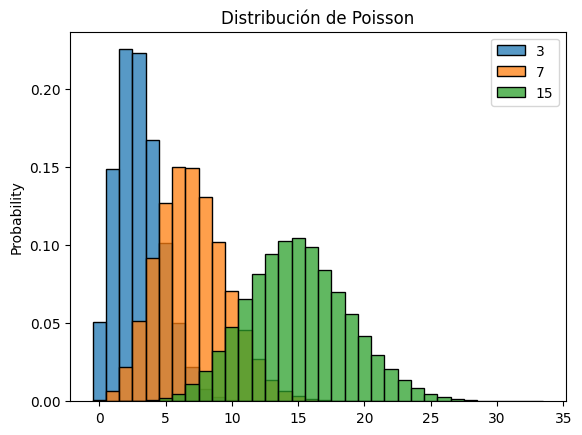

In [13]:
# Valor esperado de sucesos
lam = [3,7,15]

# Simulo
for ll in lam:
  xi = np.random.poisson(ll,N)
  sns.histplot(xi,label=ll,stat='probability',discrete=True).set(title='Distribución de Poisson')
plt.legend()
plt.show()

Una propiedad interesante es que la distirbución de Poisson y la distribución Binomial convergen en ciertos casos.

Si la probabilidad de éxito es baja (`p<0.1`) y la cántidad de eventos es alta (`n>30`) entonces la distribución binomial se asemeja a una distribución de Poisson de parámetro `lam=p*n`.

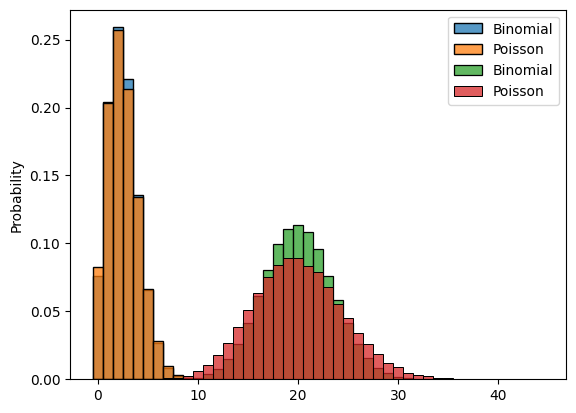

In [14]:
n = 50
p = [0.05,0.4]

for pval in p:
  sim_N = np.zeros(N)
  sim_P = np.random.poisson(n*pval,N)
  for ni in range(N):
    sim_N[ni] = np.random.binomial(n,pval)
  sns.histplot(sim_N,label="Binomial",stat='probability',discrete=True)
  sns.histplot(sim_P,label="Poisson",stat='probability',discrete=True)
plt.legend()
plt.show()

Cómo se ve arriba, las curvas se parecen para valores bajos de p (menores a 0.1). Esto es muy útil porque permite simplificar el modelo al pasar de 2 parámetros a ajustar a uno solo que es el producto de ambos, que además es más fácil de estimar en una campaña de medición para ciertos procesos naturales.

Para valores mayores de p, la función binomial se asemeja más a una distribución normal (la distribución de poisson no logra ajustar el desvío).

### Variables aleatorias continuas

Continuando con las variables continuas, pasemos rápidamente por aquellas que nos econtraremos más habitualmente. Si aparecen otras a lo largo del curso, las iremos viendo.

#### Distribución normal

Bueno, ¡la más conocida de todas! Por el Teorema Central del Limite un gran número de variables terminan convergiendo a una variable aleatoria normal o gaussiana. En general la usamos para modelar la variación de valores en una muestra del mismo proceso (la altura de las personas, la resistencia del hormigón elaborado en planta). Queda definida por su valor medio `mu` y su desvío estandar `sigma`.

$$p(x | \mu, \sigma) = \frac{1}{\sigma \sqrt{2 \pi}} e^{-\frac{1}{2}\left(\frac{x-\mu}{\sigma}\right)^{2}}$$

Cuando la media es 0 y el desvío 1 se habla de una distribución normal normalizada. La podemos simular mediante `np.random.normal`

In [15]:
#Los parámetros de la distribución:loc = media, scale = desvío estándar
mu = 0
sigma = 1

N = 10000
M_Sim = rng.normal(mu,sigma,N)

Ahora, para distribuciones continuas el histograma como vieron antes ya no es tán lindo para presentar los resultados porque depende de la cantidad de bins. Así que en estos casos es útil presentar la simulación en conjunto con la curva de densidad empírica por ventanas para tener una mejor idea de la forma.

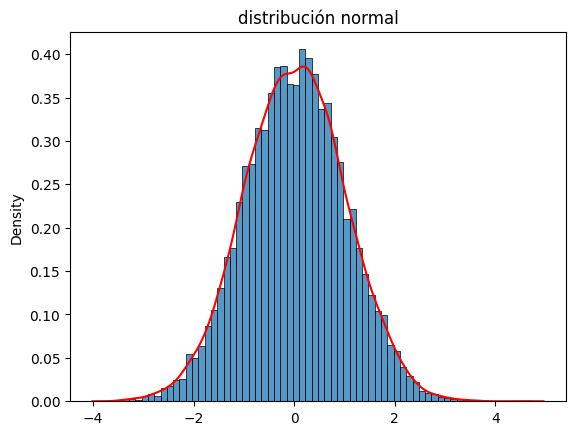

In [16]:
sns.histplot(M_Sim,stat='density').set(title='distribución normal')
sns.kdeplot(M_Sim,color='red')
plt.show()

Veamos entonces cuál es la influencia de los parámetros de la distribución.

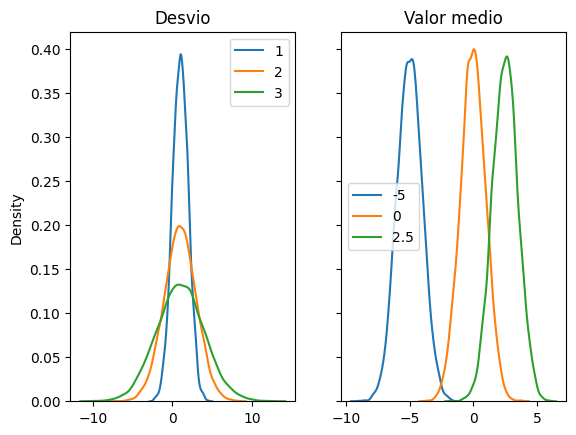

In [17]:
# Crear figura con 2 subfiguras dispuestas en columnas
fig4, ax = plt.subplots(1,2, sharey = True)

# Armar modelos para distintos 'sigma'
mu = 1
sigma = [1, 2, 3]
for sval in sigma:
  M_Sim = rng.normal(mu,sval,N)
  sns.kdeplot(M_Sim,label=sval,ax=ax[0])
ax[0].legend()
ax[0].set_title('Desvio')

# Armar modelos para distintos 'mu'
mu = [-5, 0, 2.5]
sigma = 1
for mval in mu:
  M_Sim = rng.normal(mval,sigma,N)
  sns.kdeplot(M_Sim,label=mval,ax=ax[1])
ax[1].legend()
ax[1].set_title('Valor medio')
plt.show()

####Distribución lognormal

si la variable `x` tiene una distribución normal, entonces la variable `y = ln(x)` sigue una dsitrbución lognormal, que suele ser utilizada para funciones de distribución de extremos. Por ejemplo, los $mm$ de precipación en una lluvia puede seguir una distribución aproximadamente normal, mientras que la máxima lluvia en $mm$ en un período de tiempo sigue una distribución aproximadamente lognormal.

$$p(x|m,s) = \frac{1}{x s \sqrt{2 \pi}} e^{-\frac{1}{2}\left(\frac{\ln{x}-m}{s}\right)^{2}},\ x\geq0$$

Los parámetros de la distribución lognormal son en principio 2: la forma `s` (igual al desvio estandar de la distribucion normal) y la mediana `m` (relacionada con el valor medio de la distribución normal mediante la exponenciación).

Muchas veces (por ejemplo, en Numpy), a la distirbución lognormal se la escribe en función de los parámetros de su distribución normal asociada. En ese caso, se debe recordar que el valor medio de la distribución normal es el logaritmo natural de la mediana de la distribución lognormal.

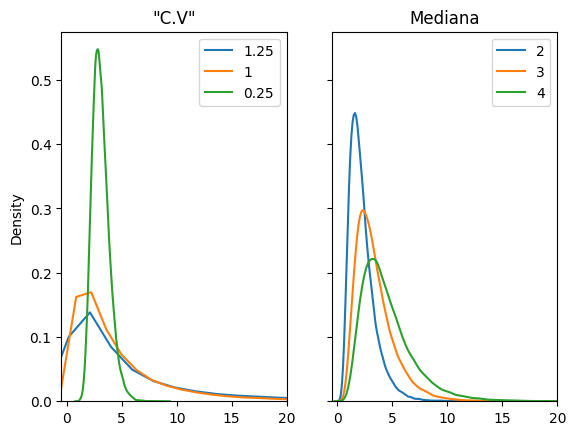

In [18]:
# Crear figura con 2 subfiguras dispuestas en columnas
fig5, ax = plt.subplots(1,2, sharey = True, sharex = True)

N = 100000
# Armar modelos para distintos 'sigma'
mu = 3
sigma = [1.25, 1, 0.25]
for sval in sigma:
  M_sim = rng.lognormal(np.log(mu),sval,N)
  sns.kdeplot(M_sim,label=sval,ax=ax[0])
ax[0].legend()
ax[0].set_title('"C.V"')

# Armar modelos para distintos 'mu'
mu = [2, 3, 4]
sigma = 0.5
for mval in mu:
  M_sim = rng.lognormal(np.log(mval),sigma,N)
  sns.kdeplot(M_sim,label=mval,ax=ax[1])
ax[1].legend()
ax[1].set_title('Mediana')

plt.xlim([-0.5, 20])
plt.show()

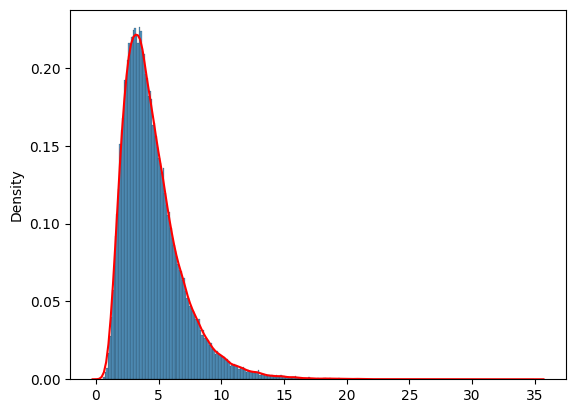

In [19]:
sns.histplot(M_sim,stat='density')
sns.kdeplot(M_sim,color='red')
plt.show()

La distribución lognormal está en general definida entre 0 e infinito, pero es posible correr el espacio de la variable. ¿Cómo lo harían?

También podría construirme a la distribución lognormal a partir de la simulación de variables aleatorias normales.

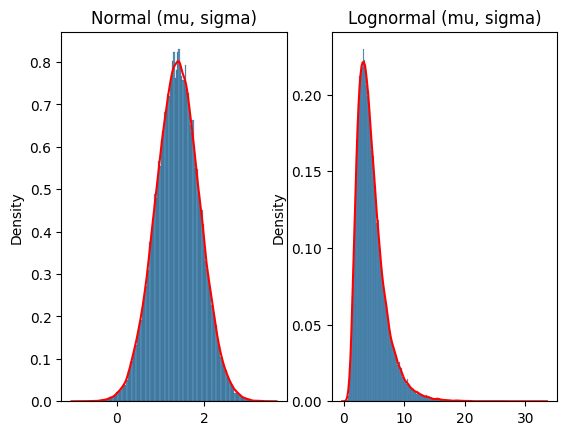

In [20]:
# Simulo una variable aleatoria normal
M_sim = rng.normal(np.log(mval),sigma,N)

# Aplico exponenciacion (Transformo simulaciones)
E_sim = np.exp(M_sim)

# Crear figura con 2 subfiguras dispuestas en columnas
fig5, ax = plt.subplots(1,2)

sns.histplot(M_sim,stat='density',ax=ax[0])
sns.kdeplot(M_sim,color='red',ax=ax[0]).set(title='Normal (mu, sigma)')

sns.histplot(E_sim,stat='density',ax=ax[1])
sns.kdeplot(E_sim,color='red',ax=ax[1]).set(title='Lognormal (mu, sigma)')
plt.show()


#### Distribución t-student

Siguiendo con la idea de transformar variables, veamos cómo simular en Numpy una distribución t-student no estandarizada. Imaginensé que tienen una Variable Aleatoria $X$ gobernada por:

$$X \sim student-t(\nu,\mu,\tau)$$

también la van a encontrar como $t_{\nu}(\mu,\tau)$

- $\nu$ se refiere a los "grados de libertad" (¿se acuerdan de Probabilidad y Estadística? Cuando $\nu→∞$ entonces la t-student se transforma en una distribución normal)
- $\mu$ es el valor medio de la distribución o factor de ubicación
- $\tau$ es el factor de escala, cumple el mismo rol que el desvío estándar en la función (dividiendo a la variable), pero eso no quiere decir *que sea igual al desvío estandar*. Eso solo ocurre cuando $\nu→∞$

El problema que tenemos es que Numpy sólo tiene disponible para simular a la t-student standard ($\mu=0$, $\tau=1$). Entonces, para simularla vamos a tener que hacer una transformación de variables. Si

$$Z = \frac{X-\mu}{\tau}$$

¡Entonces $Z$ es una distribución t-standard (por eso se llaman factores de locación y escala)!

$$X \sim standard-t(\nu)$$

también la van a encontrar como $t_{\nu}$

El proceso consiste entones en:
1. Simular $Z$ como t-standard con $\nu$ grados de libertad
2. Calcular $X=Z*\tau+\mu$

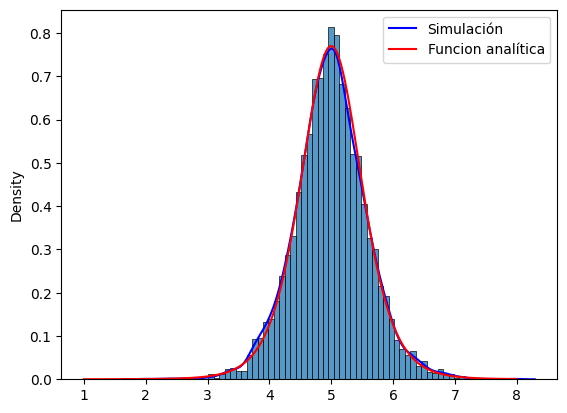

In [21]:
mu = 5
tau = 0.5
nu = 7

# Simulaciones
N = 4000

# Simulo Z
Z = rng.standard_t(nu,N)
# Transformo a X
X = Z*tau+mu

# Funcion analitica para chequear
import scipy.stats as st
tmodel = st.t(nu,loc=mu,scale=tau)
xi = np.array(range(1000,8000))/1000
ti = tmodel.pdf(xi)

## Grafico
sns.histplot(X,stat='density')
sns.kdeplot(X,label='Simulación',color='blue')
plt.plot(xi,ti,label='Funcion analítica',color='red')
plt.legend()
plt.show()

####Distribución exponencial

Se llama así porque la función de densidad de probabilidad es una exponencial negativa. Queda definida por el parámetro `lambda` y va, en general, de 0 a infinito, aunque es posible hacer un corrimiento igual que para el caso lognormal.

$$p(x|\lambda) = \lambda e^{-\lambda x},\ x\geq0$$

Se suele usar para mediciones de tiempo (por ejemplo, el tiempo entre pasos de autos podría ser modelado por una distribución exponencial)

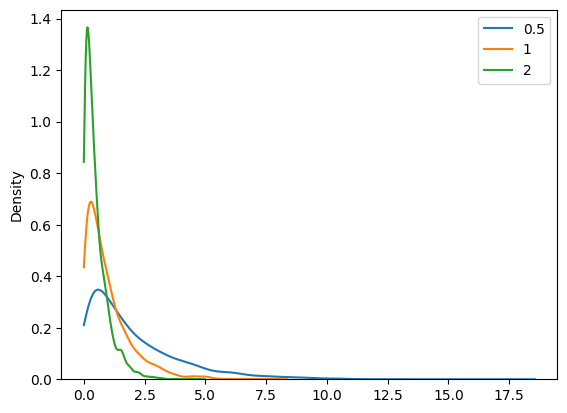

In [22]:
lam = [0.5, 1, 2]

Modelo = []
for l in lam:
  M_sim = rng.exponential(1/l,N)
  sns.kdeplot(M_sim,label=l,clip=[0, np.inf])

plt.legend()
plt.show()

Como comentario, vean que una función de densidad de probabilidad puede tener valores mayores a 1, a diferencia de las funciones de masa para variables discretas.

NOTA: análiticamente la función de densidad tiende a infinito en 0, pero obviamente al cálculo empírico nunca le va a dar para eso, se ve una caída abrupta porque no hay nada del otro lado del 0 y me lo "promedia"

#### Distribución uniforme

Asume que la variable puede tomar con igual probabilidad cualquier valor dentro del intervalo [a, b]. Se la utiliza mucho para samplear muestras de variables, como punto de partida para la inferencia estadística, o para modelar errores de medición.

$$p(x|a,b) = \frac{1}{b-a},\ a\leq x \leq b$$

Ya vimos como funciona, ¡así que no hace falta repetirlo!

#### Otras

Podríamos seguir todo el día con funciones: Gumbel, Gamma, Beta, etc... a medida que aparezcan las seguiremos viendo, mientras pueden ir buscando en la página de `numpy.random` todas las que ya están programadas y cómo funcionan (recomiendo ver la t-student, por ejemplo).

## Funciones de distribución de probabilidad (multivariadas)

### Distribución Multinomial

Como un último ejemplo, la distribución multinomial es la extensión de la distribución binomial para variables categóricas (es decir, hace un conteo de resultados para n eventos, con la diferencia de que en cada evento puede haber más de 2 resultados posibles).

Como no es posible gráficar la distribución de probabilidad si se tienen más de 2 resultados, se mostrará un ejemplo que degenera en una distribución binomial.

La distribución es multivariada porque la probabilidad es $p(\mathbf{x}=\mathbf{k}|\mathbf{p},n)$ con $x,k,p$ siendo vectores de la misma longitud que la cantidad de distintas categorías posibles.

In [23]:
n = 3 # numero de eventos
p = [0.4, 0.6] # probabilidad de resultados 0, 1, la suma da 1.

# Simular N veces un ensayo donde saco n eventos con probabilidad p para cada
# categoria
Falla_Sim = rng.multinomial(n, p, N)

# Cada columna es una categoria, cada fila es una simulación, los números en las
# celdas muestran cuántas veces ocurrió cada caso.
print(Falla_Sim[0:3,:])

[[0 3]
 [2 1]
 [1 2]]


In [24]:
# Estimo las probabilidades por simulación
pvals = np.array([])
for nj in range(n+1):
  for ni in range(n+1):
    pvals = np.append(pvals,np.mean((Falla_Sim[:,0]==ni) & (Falla_Sim[:,1]==nj)))
print(pvals)

[0.     0.     0.     0.058  0.     0.     0.2865 0.     0.     0.432
 0.     0.     0.2235 0.     0.     0.    ]


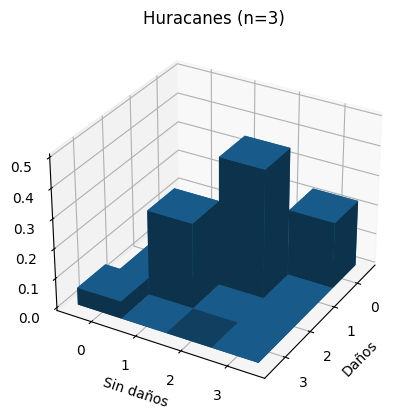

In [25]:
# Crear la grilla de valores para cada conteo ('x', 'y')
# rango de valores a considerar
xpos = np.arange(0,4,1)
ypos = np.arange(0,4,1)
# crear un mesh con todas las combinaciones
xpos, ypos = np.meshgrid(xpos,ypos)
# Convertir de matrices a vector
xpos = xpos.flatten()
ypos = ypos.flatten()

# Crear la matriz combinando 'x' e 'y'
XY = np.transpose(np.array([xpos,ypos]))

# Iniciar figura, indicar que es en 3D
fig = plt.figure()
ax = plt.axes(projection = '3d')
ax.view_init(30,30) # Setear la vista

# Agregar barras 3D, con offsets para centrarlas
N = len(xpos)
ax.bar3d(xpos-0.5,ypos-0.5,np.zeros(N),np.ones(N),np.ones(N),pvals)
ax.set_xticks(range(n+1))
ax.set_yticks(range(n+1))
ax.set_zticks(np.linspace(0,0.5,6))
ax.set_xlabel('Daños')
ax.set_ylabel('Sin daños')
ax.set_title('Huracanes (n=3)')
plt.show()

### Distribución Normal multivariada

Por último, vamos a cerrar con la extensión de la distribución normal para problemas de más de una variable. Por ejemplo, imagenimos la distribución que explica la probabilidad de personas con determinado peso $X$ y altura $Y$. Las distribuciones marginales de cada una de ellas es supongamos Normal, pero ¿que pasa con la combinación?

La combinación es una distribución normal multivariada, donde entra en juego también la *relación* entre la variables, que queda descripta por una matriz de covarianzas.

A continuación les dejamos un poco de background teórico de qué representan los parámetros de esta función (son básicamente, los valores medios, los desvíos estándar y la correlación entre variables).


Consideremos un vector aleatorio $X$. Su *esperanza* se define componente a componente, y es un nuevo vector (no aleatorio)

$$X=\begin{pmatrix}
X_{1} \\
X_{2} \\
\ldots  \\
X_{n}
\end{pmatrix}\in \mathbb{R} ^{n}\Rightarrow \mu_x = E\left[ X\right] =\begin{pmatrix}
E\left[ X_{1}\right]  \\
E\left[ X_{2}\right]  \\
\ldots  \\
E\left[ X_{n}\right]
\end{pmatrix}\in \mathbb{R} ^{n}$$

Definimos su *matriz de covariancias* $\Sigma =\Sigma_x=Cov$  por $\Sigma _{ij}=Cov\left( X_{i},X_{j}\right) $

$$\Sigma_x=Cov\left( X\right) = \begin{pmatrix}
Cov\left( X_{1},X_{1}\right)  & Cov\left( X_{1},X_{2}\right)  & \ldots  & Cov\left( X_{1},X_{n}\right)  \\
Cov\left( X_{2},X_{1}\right)  & Cov\left( X_{1},X_{2}\right)  & \ldots  & Cov\left( X_{2},X_{n}\right)  \\
\ldots  &  &  &  \\
Cov\left( X_{n},X_{1}\right)  & Cov\left( X_{n},X_{2}\right)  & \ldots  & Cov\left( X_{n},X_{n}\right)
\end{pmatrix} \in \mathbb{R} ^{n\times n}$$

Notamos que es una *matriz simétrica.* Tambien podemos decir

$$Cov\left( X\right) =E\left[ ( X-\mu_x )\cdot \left( X-\mu _{x}\right) ^{t}\right] $$

Notemos que en la diagonal de la matriz de covariancias $Cov(X)$ aparecen las variancias:

$$\sigma _{x_{i}}^{2}=Cov(X_i,X_i)=Var(X_i)$$

Otra observación interesante es que si las componentes del vector X son independientes, entonces serán no correlacionadas:

$Cov(X_i,X_j)=0$ si $i\neq j$ por lo que la matriz $Cov(X)$ será diagonal.

Ejemplo: si $X$ es un vector con componentes $X_{i}\sim N\left( 0,1\right) $ independientes su densidad conjunta vendrá dada por

$$f\left( x\right) =\prod ^{n}_{i=1}\dfrac{1}{\sqrt{2\pi }}e^{-x_{i}^{2}/2}=\dfrac{1}{\left( 2\pi \right) ^{n/2}} e^{-\left| \left| x\right| \right| ^{2}/2}$$

Siendo
$$E\left[ X\right] =\overrightarrow{O}, \quad Cov\left( X\right) =I$$

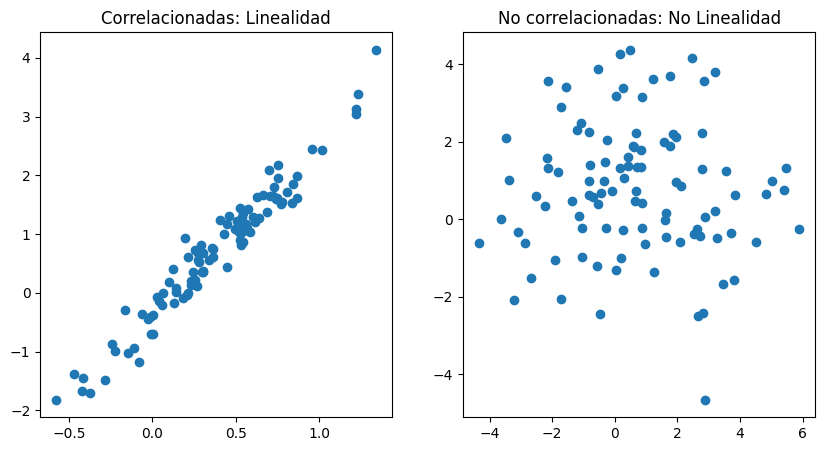

In [26]:
#Parámetros
mean = np.array([0.4,0.8])
cov_1 = np.array([[0.1, 0.3], [0.3, 1.0]])
cov_2 = np.array([[5, 0], [0, 3]])

#Variables aleatorias
x_1 = rng.multivariate_normal(mean, cov_1, 100)
x_2 = rng.multivariate_normal(mean, cov_2, 100)

#Gráfico de puntos
fig, axs = plt.subplots(1, 2, figsize=(10,5))

axs[0].scatter(x_1[:,0],x_1[:,1])
axs[0].set_title('Correlacionadas: Linealidad')

axs[1].scatter(x_2[:,0],x_2[:,1])
axs[1].set_title('No correlacionadas: No Linealidad')

plt.show()

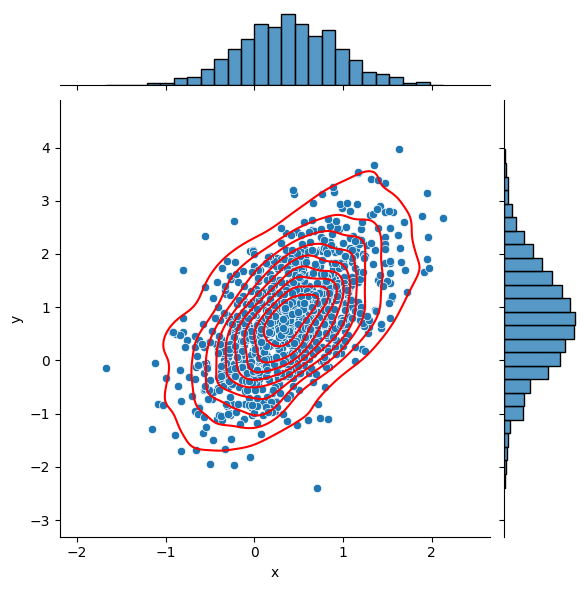

In [27]:
x = np.linspace(-2, 2, 201)
y = np.linspace(-4, 4, 201)

#Los pares ordenados (x, y) a evaluar
X, Y = np.meshgrid(x, y)
pos = np.dstack((X, Y))

mean = np.array([0.4,0.8])
cov = np.array([[0.3, 0.3], [0.3, 1.0]])

Data = rng.multivariate_normal(mean, cov, 1000)

a = sns.jointplot(data=pd.DataFrame({'x':Data[:,0],'y':Data[:,1]}), x="x", y="y")
a.plot_joint(sns.kdeplot, color="r")
plt.show()

#sns.histplot(data=pd.DataFrame({'x':Data[:,0],'y':Data[:,1]}), x="x", y="y")
#plt.show()

## Funciones de probabilidad acumulada (y otras yerbas)

Hasta ahora vimos cómo se ven y como simular un conjunto de funciones de densidad de probabilidad. Para visualizarlas lo hicimos hasta ahora en función de histogramas de frecuencia o densidad, y de funciones de densidad empíricas por ventanas.

Lo que nos faltaría ahora es aprender a sacarle más información a esos datos, como por ejemplo:

1. ¿Cómo calculo una probabilidad?
2. ¿Cómo calculo una probabilidad condicional?
3. ¿Cómo obtengo percentiles y la función de probabilidad acumulada?

Todo eso es lo que vamos a ver ahora (¡en parte ya lo hemos estado usando!)

### Cálculo de probabilidades

Empecemos por lo más fácil. Si quiero saber la probabilidad de que la cantidad de terremotos el próximo año sea 3, sabiendo que la cantidad de terremos al año sigue una distribución de poisson con $\lambda=1$, qué hago?

¿Y si ni supiera, pero tengo datos de los últimos 50 años?

Puedo hacer ambas de igual forma, ¡por conteo!

In [28]:
# Valor esperado de sismos en el año
lam = 1

# Simulo 10000 años
N = 10000
sims = rng.poisson(lam,N)

# Calculo el promedio
mu = np.mean(sims)
print('El valor medio de sismos por año es',mu)

# Calculo la varianza
s2 = np.var(sims,ddof=1)
print('La varianza es',s2)

# Hago la cuenta de casos en los que la simulación dio 3
P3 = np.mean(sims==3)
print('La probabilidad de que haya 3 sismos en un año es',P3)

# Solucion analitica (para que vean nomás que funciona)
pmodel = st.poisson(lam)
p3an = pmodel.pmf(3)
print('(Solución analítica:',round(p3an,4),')')

# Hago la cuenta de casos en los que la simulación dio entre 1 y 3
P13 = np.mean((sims>=1) & (sims<=3))
print('La probabilidad de que haya entre 1 y 3 en un año es',P13)

El valor medio de sismos por año es 0.9947
La varianza es 1.0007719871987202
La probabilidad de que haya 3 sismos en un año es 0.0597
(Solución analítica: 0.0613 )
La probabilidad de que haya entre 1 y 3 en un año es 0.6097


In [29]:
sims[10:20]

array([1, 1, 2, 1, 0, 1, 0, 2, 0, 0])

Así de fácil!

NOTA: Mientras más me voy hacia las colas de la distribución, más datos necesito para tener una estimación precisa.

Vamos por otra: ¿Cuál es la probabilidad de que ocurran 4 sismos en 2 dos años dado que durante el primer año ocurrieron tres?

NOTA: Si $\lambda=1$ es el parámetro de la distribución en un año, $\lambda=2$ es el parámetro de la distribución para dos años.

Esto también lo podemos hacer por conteo, viendo cuántas veces ocurrieron 4 sismos en 2 años sabiendo que ocurrieron 3 sismos en un año.

In [30]:
N=1000000

# Simulo Año 1
A1 = rng.poisson(lam,N)

# Simulo Año 2
A2 = rng.poisson(lam,N)

# Simulación total
AT = A1+A2

# Cantidad de casos con 3 sismos en el año 1
N1 = np.sum(A1==3)

# Cantidad de casos donde el resultado de los 2 años es 4 después de un primer año con 3
Asel = AT[A1==3] # Selecciono los casos en los que primero ocurrieron 3 sismos
N2 = np.sum(Asel==4)

# Probabilidad
P = N2/N1
print('La probabilidad es',P)
print('Nota, la probabilidad de que en 1 año haya 1 sismo es:',np.mean(A1==1))

La probabilidad es 0.3711094418498318
Nota, la probabilidad de que en 1 año haya 1 sismo es: 0.367883


No es casualidad que de lo mismo, los incrementos en un proceso de Poisson son independientes de lo que haya pasado antes (una propiedad similar a la falta de memoria de la distribución exponencial)

Hasta ahora venimos haciendo la cuenta para igualdades, pero también se puede hacer para semiplanos, distribuciones conjuntas, marginales, etc, que tendrán sentido según el caso. ¡La idea es exactamente la misma! Chequear en forma lógica, y contar cuántas veces ocurren.

### Función de probabilidad acumulada

La función de probabilidad acumulada queda definida como:

$$F(x)=P(X\leq x)$$

De donde se puede demostrar que es una función monóticamente creciente cuyo limite para cuando x tiende a menos infinito es 0 y cuando tienda a más infinito es 1, y que, a su vez en variables continuas:

$$p(X=x)=\frac{∂ F(x)}{\partial x}$$

Es decir, la función de densidad de probabilidad es la derivada.

Calcularla en forma empírica dados los datos entonces consiste en:
1. ordenar las simulaciones de menor a mayor
2. (opcional) generar un nuevo vector con los datos únicos. En variables continuas esto no importa porque la probabilidad de que un número se repita es nulo. La verdad, sólo simiplifica la parte de graficar esto.
3. para cada valor único y ordenado, calcular por conteo la probabilidad de que los datos se encuentren por debajo de ese valor.

¿Lo hacemos? ¡Sale en una línea!

Para una Poisson:

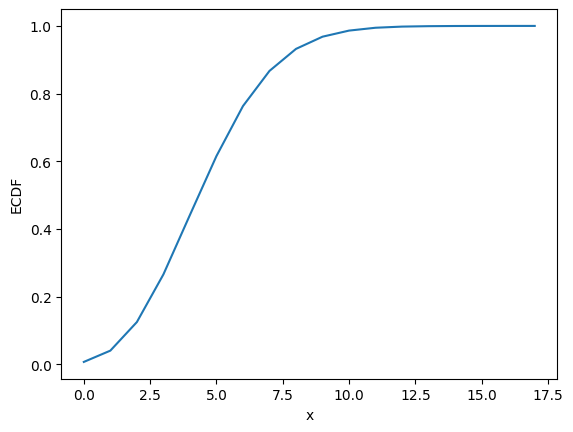

In [31]:
# Parametro
lam = 5
# Simulaciones
N = 100000

# Obtengo datos
Sim = rng.poisson(lam,N)

# Ordeno resultados
S_sort = np.sort(Sim)

# Datos únicos
S_uniq = np.unique(S_sort)

# Curva empírica
ECDF = np.array([np.mean(S_sort<=xi) for xi in S_uniq])

sns.lineplot(pd.DataFrame({'x':S_uniq,'ECDF':ECDF}),x='x',y='ECDF')
plt.show()

Lo anterior también se puede ver con un seaborn, pero es más dificil de trabajarlo después.

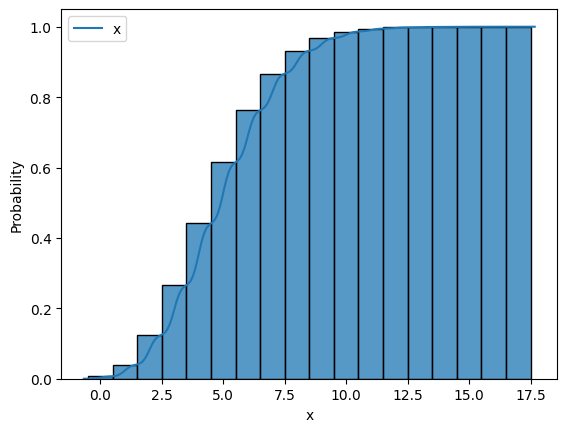

In [32]:
sns.histplot(pd.DataFrame({'x':Sim}),x='x',stat='probability',cumulative=True,discrete=True)
sns.kdeplot(pd.DataFrame({'x':Sim}),cumulative=True)
plt.show()

¿Con qué me refiero a trabajarlo? Por ejemplo, ¡calculando cuantiles!


In [33]:
# Cuantil 80
Q80 = np.min(S_uniq[ECDF>=0.8])

print('El cuantil 80 es de ',Q80)

# Verificacion con función de Numpy
print(np.quantile(Sim,0.8))

El cuantil 80 es de  7
7.0


Y lo mismo podemos hacer para una V.A. continua:

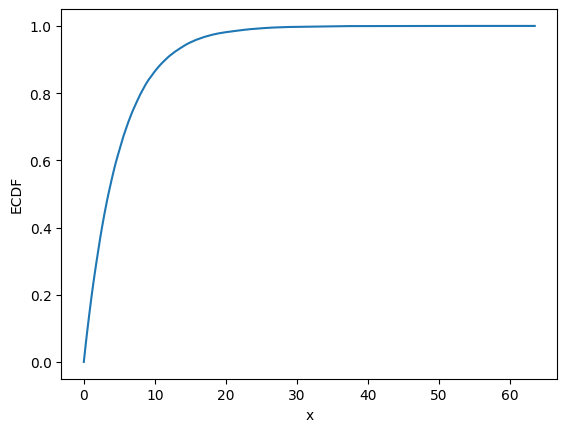

In [34]:
# Parametro
lam = 5
# Simulaciones
N = 100000

# Obtengo datos
Sim = rng.exponential(lam,N)

# Ordeno resultados
S_sort = np.sort(Sim)

# Datos únicos
S_uniq = np.unique(S_sort)

# Curva empírica
ECDF = np.array([np.mean(S_sort<=xi) for xi in S_uniq])

sns.lineplot(pd.DataFrame({'x':S_uniq,'ECDF':ECDF}),x='x',y='ECDF')
plt.show()

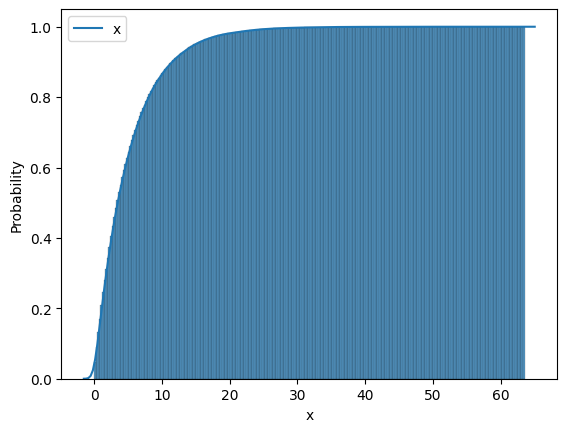

In [35]:
sns.histplot(pd.DataFrame({'x':Sim}),x='x',stat='probability',cumulative=True)
sns.kdeplot(pd.DataFrame({'x':Sim}),cumulative=True)
plt.show()

In [36]:
# Cuantil 80
Q80 = np.min(S_uniq[ECDF>=0.8])

print('El cuantil 80 es de ',Q80)

# Verificacion con función de Numpy
print(np.quantile(Sim,0.8))

El cuantil 80 es de  8.03847430302854
8.038535413604144


Nota: no da exactamente igual por que np.quantile define ligeramente distinto las probabilidades acumuladas y utiliza interpolación. Si se quiere se puede editar la forma en que lo hace, pero a fines prácticos no importa.

## Ejercicio 1: Cálculo de Probabilidades y Distribuciones Marginales.

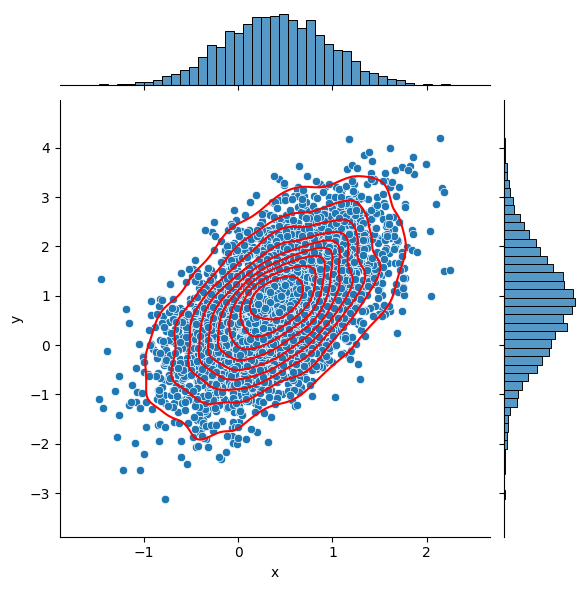

In [37]:
x = np.linspace(-2, 2, 201)
y = np.linspace(-4, 4, 201)

#Los pares ordenados (x, y) a evaluar
X, Y = np.meshgrid(x, y)
pos = np.dstack((X, Y))

mean = np.array([0.4,0.8])
cov = np.array([[0.3, 0.3], [0.3, 1.0]])

Data = rng.multivariate_normal(mean, cov, 4000)

a = sns.jointplot(data=pd.DataFrame({'x':Data[:,0],'y':Data[:,1]}), x="x", y="y")
a.plot_joint(sns.kdeplot, color="r")
plt.show()

¿Cómo calcularía?
1. La probabilidad de que X sea menor a 1
2. La probabilidad de que Y sea menor a 2
3. La probabilidad de que X sea menor a 1 dado que Y es menor a 2
4. La probablilidad de que X sea menor a 1 e Y sea menor a 2.
5. La función de probabilidad acumulada de X
6. La función de probabilidad acumulada de X dado Y entre 0 y 1

En base a los resultados, ¿puede distinguir si X e Y son independientes?

In [38]:
# Solucion 1
S1 = np.mean(Data[:,0]<1)
print('Solucion 1:',S1)

# Solucion 2
S2 = np.mean(Data[:,1]<2)
print('Solucion 2:',S2)

# Solucion 3
S3 = np.mean(Data[Data[:,1]<2,0]<1)
print('Solucion 3:',S3)

# Solucion 4
S4 = np.mean((Data[:,0]<1) & (Data[:,1]<2))
print('Solucion 4:',S4)
print('Nota, S1*S2:',S1*S2)

Solucion 1: 0.85875
Solucion 2: 0.878
Solucion 3: 0.8989179954441914
Solucion 4: 0.78925
Nota, S1*S2: 0.7539825


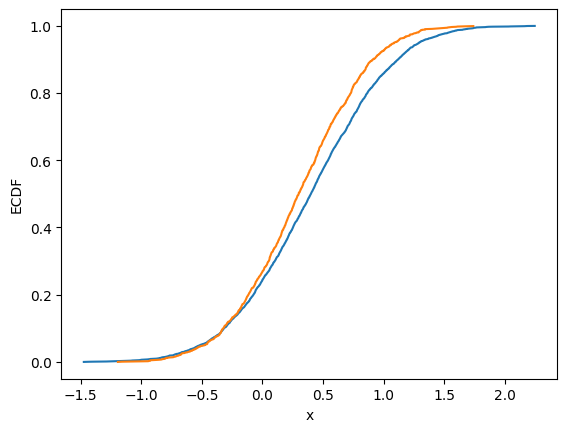

In [39]:
X5sort = np.sort(Data[:,0])
S5 = np.array([np.mean(Data[:,0]<xi) for xi in X5sort])

X6sort = np.sort(Data[(Data[:,1]>0) & (Data[:,1]<1),0])
S6 = np.array([np.mean(Data[(Data[:,1]>0) & (Data[:,1]<1),0]<xi) for xi in X6sort])

sns.lineplot(pd.DataFrame({'x':X5sort,'ECDF':S5}),x='x',y='ECDF')
sns.lineplot(pd.DataFrame({'x':X6sort,'ECDF':S6}),x='x',y='ECDF')
plt.show()

De los resultados se desprenden que no son indenpendientes. De serlo:
1. La solución 1 y 3 serían iguales (no debiera depender de Y)
2. La solución 4 debiera ser igual al producto de las soluciones 1 y 2 (se acuerdan de probabilidad conjunta?)
3. Las distribuciones marginales empíricas de 5 y 6 debieran ser iguales (independientes de Y)

## Ejercicio 2: Definición de PGA de diseño

La máxima aceleración $a$ en el sitio debido a un sismo de magnitud $M$ con epicentro a una distancia $R$ puede ser evaluada a partir de una ley de atenuación calibrada para el sitio:

$a = b_{1} e^{b_{2}M} R^{b_{3}}$

Aún asumiendo que el modelo es determinístico (no hay incertidumbre en los parámetros $b$ ni en la forma de la ecuación), la magnitud del sismo $M$ y la distancia al epicentro $R$ son variables aleatorias.

Asumiendo que el máximo sismo en 50 años $M$ responde a una Gumbel (de paso vemos cómo es) con media 7 y desvío estándar 1.5 y que la distancia $R$ es una distribución uniforme entre 60 y 80 km, encuentre el valor de aceleración $a$ con período de retorno 475 años. (probabilidad 1/475 de ser superado en cada año)

Para resolver este problema, en vez de buscar una solución analítica (no la hay), vamos a simular valores de M y R y construir empíricamente la función de distribución.

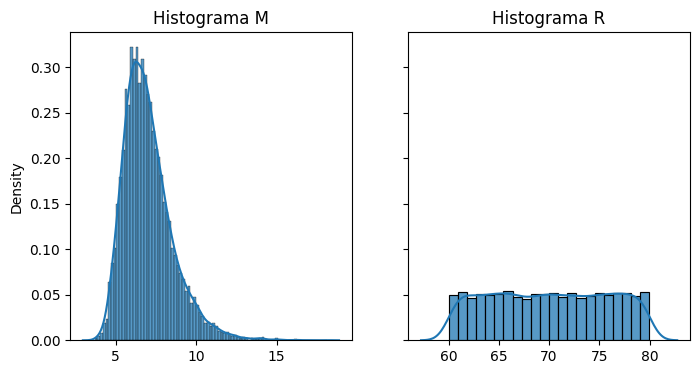

In [40]:
# Número de muestras
Nsample = 10000

# Modelo para M
mean, sigma = 7, 1.5

beta = sigma*np.sqrt(6)/np.pi # Parametro de escala
mu = mean - beta*np.euler_gamma # Parametro de locacion (moda)
Mmodel = rng.gumbel(mu,beta,Nsample)

# Modelo para R
xi, xf = 60, 80
Rmodel = rng.uniform(xi,xf,Nsample)

# Ver histogramas
fig, axs = plt.subplots(1, 2, figsize=(8,4), sharey=True)

sns.histplot(Mmodel,stat='density',ax=axs[0]).set(title='Histograma M')
sns.kdeplot(Mmodel,ax=axs[0])
sns.histplot(Rmodel,stat='density',ax=axs[1]).set(title='Histograma R')
sns.kdeplot(Rmodel,ax=axs[1])
plt.show()

La simulación de las variables se ve bien, así que podemos ahora hacer lo mismo para $a$

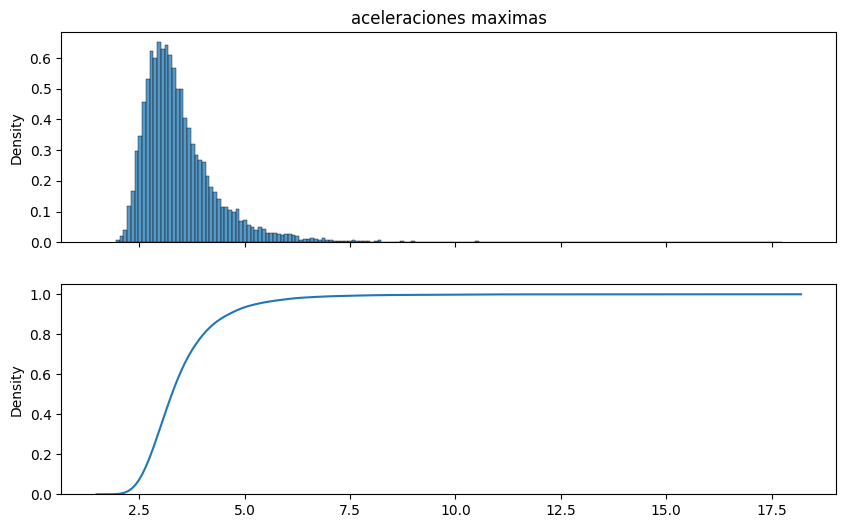

In [41]:
# Parametros regresión
b1,b2,b3 = 23, 0.15, 0.7

# Aplicamos la regresion
avals = b1*np.exp(b2*Mmodel)*Rmodel**(-b3)

fig,ax = plt.subplots(2,1,figsize=(10,6),sharex=True)
sns.histplot(avals,stat='density',ax=ax[0]).set(title='aceleraciones maximas')
sns.kdeplot(avals,ax=ax[1],cumulative=True)
plt.show()

La curva que encontramos arriba en forma empírica es para la máxima aceleración en 50 años. Tenemos que encontrar ahora el valor con período de retorno 475 años (es una excedencia anual). La relación es:

$\frac{1}{475}=1-P_{1}(a)=1-\sqrt[50]{P_{50}(a)}$

de donde sale que buscamos el valor de a tal que

$P_{50}(a) = \left(1-\frac{1}{475}\right)^{50}$

A fines prácticos, podemos buscar el índice de la CDF más cercano al valor de arriba, y luego tomar el valor de $a$ asociado.

In [42]:
# Probabilidad buscada
P50 = (1-1/475)**50

# Encontrar el valor más cercano en nuestra CDF experimental
asort = np.sort(avals)
ECDF = np.array([np.mean(avals<=xi) for xi in asort])
Solution = np.min(asort[ECDF>=P50])

# Opcion B
Solution2 = np.quantile(avals,P50)

print('P50:',P50)
print('a475:',Solution, 'm/s^2')
print('a475:',Solution2, 'm/s^2')

P50: 0.89998775889488
a475: 4.611166215789757 m/s^2
a475: 4.611150107484987 m/s^2
